In [1]:
import os

import pandas  as pd
import seaborn as sns

from matplotlib.pyplot import subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVC
from sklearn.metrics         import classification_report

from aequitas.preprocessing import preprocess_input_df
from aequitas.group         import Group
from aequitas.bias          import Bias
from aequitas.fairness      import Fairness
from aequitas.plotting      import Plot


%matplotlib inline

In [2]:
# global variables

DATASET_PATH = os.path.join(os.getcwd(), "hearth_disease.csv")

# 1. What is the dataset ?

The dataset pertains to the diagnosis of heart disease and consists of numeric-valued attributes. It contains 694 instances, with only 12 attributes being used for analysis, which are described as below:

   
   01. `age`: displays the age of the individual in years.
   
   
   02. `sex`: displays the gender of the individual using the following format:
      * 0 = Female
      * 1 = Male
   
   
   03. `cp`: displays the type of chest-pain experienced by the individual using the following format:
      * 1 = Typical angina
      * 2 = Atypical angina
      * 3 = Non-anginal pain
      * 4 = Asymptotic
   
   
   04. `trestbps`: displays the resting blood pressure value of an individual in mmHg (unit).
   
   
   05. `chol`: displays the serum cholesterol in mg/dl (unit).
   
   
   06. `fbs`: compares the fasting blood sugar value of an individual with 120 mg/dl. If fasting blood sugar > 120 mg/dl then it is 1 (true), otherwise it is 0 (false).
   
   
   07. `restecg`: displays resting electrocardiographic results using the following format:
      * 0 = Normal
      * 1 = Having ST-T wave abnormality
      * 2 = Left ventricular hyperthrophy
   
   
   08. `thalach`: displays the max heart rate achieved by an individual.
   
   
   09. `exang`: exercise induced angina using the following format:
      * 1 = Yes
      * 0 = No
   
   
   10. `oldpeak`: displays ST depression induced by exercise relative to rest.
   
   
   11. `race`: the race of the invidual using the following format:
      * 0 = Hungarian-American
      * 1 = Swiss
   
   
   12. `num`: displays whether the individual is suffering from heart disease or not using the following format:
      * 0 = absence
      * 1 = present

In [3]:
# reading the preprocessed dataset
dataframe = pd.read_csv(DATASET_PATH, index_col = [0])
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num,race
0,32,1,1,95,0,0,0,127,0,0.7,1,1
3,36,1,4,110,0,0,0,125,1,1.0,1,1
4,38,0,4,105,0,0,0,166,0,2.8,1,1
5,38,0,4,110,0,0,0,156,0,0.0,1,1
6,38,1,3,100,0,0,0,179,0,-1.1,0,1


# 2. Preprocess the dataset and apply data formatting for Aequitas

Aequitas has several requirements for the input dataframe:

   * The dataframe must contain a `score` column, which represents a binary decision (either 0 or 1).
   
   * The dataframe must also contain a `label_value` column, which represents the ground truth value of a binary decision.
   
   * Additionally, the dataframe must have at least one attribute column (such as sex or race), which the model used to generate the score column.
   
It's important to note that Aequitas assumes the `score` and `label_value` columns are both binary-valued. The other columns in the dataframe represent attributes that were used by the model to generate the `score` column.

In our dataset, we have identified `sex` and `race` as the protected or sensitive attributes on which we should search for discrimination. Additionally, we have a `label_value` column that represents the ground truth value of a binary decision.

To generate the `score` column, we will create a classifier using a Support Vector Classifier. This classifier will use the sex and race attributes, as well as any other relevant attributes, to make binary decisions and generate scores.

In [4]:
# indicate the feature and target attributes
y = dataframe["num"]
X = dataframe.drop("num", axis = 1)

# split the dataset into train and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f"Shape of Train set: {Xtrain.shape}")
print(f"Shape of Test  set: {Xtest.shape}")

Shape of Train set: (555, 11)
Shape of Test  set: (139, 11)


In [5]:
# preprocess the dataset
scaler = StandardScaler()

Xtr = scaler.fit_transform(Xtrain)
Xts = scaler.transform(Xtest)

In [6]:
# create classifier model
model = SVC(kernel = 'rbf', C = 2)

# train model
model.fit(Xtr, Ytrain)

# make predictions over the testing set
predictions = model.predict(Xts)

print(classification_report(Ytest, predictions, target_names = ["Absence", "Present"]))

              precision    recall  f1-score   support

     Absence       0.78      0.84      0.81        68
     Present       0.83      0.77      0.80        71

    accuracy                           0.81       139
   macro avg       0.81      0.81      0.81       139
weighted avg       0.81      0.81      0.81       139



In [7]:
# create our intended dataframe that can be used through the Aequitas tool
df_aeq = pd.DataFrame()

df_aeq["score"] = predictions
df_aeq["label_value"] = list(Ytest)

df_aeq["sex"]  = list(Xtest["sex"].map({0: "Female", 1: "Male"}))
df_aeq["race"] = list(Xtest["race"].map({0: "Hungarian-American", 1: "Swiss"}))

df_aeq.head()

,score,label_value,sex,race
0,1,1,Male,Hungarian-American
1,0,0,Male,Hungarian-American
2,0,0,Female,Hungarian-American
3,1,1,Male,Hungarian-American
4,0,0,Male,Hungarian-American


# 3. Visualize and explore the results before using Aequitas

The bar charts below provide insight into potential biases of the model. One notable finding is that the model appears to have a significant bias with respect to the race of individuals, as demonstrated by its predictions for Swiss individuals. Specifically, the model predicts that all individuals from the Swiss race have a high potential for heart disease, which suggests that the model has overgeneralized based on the limited data available for this subgroup. This bias could be a result of a variety of factors, including an insufficient representation of Swiss individuals in the training data, or the presence of confounding variables that are correlated with both race and heart disease but not properly accounted for in the model. Such biases can lead to inaccurate predictions and must be addressed to ensure the fairness and accuracy of the model's outputs.

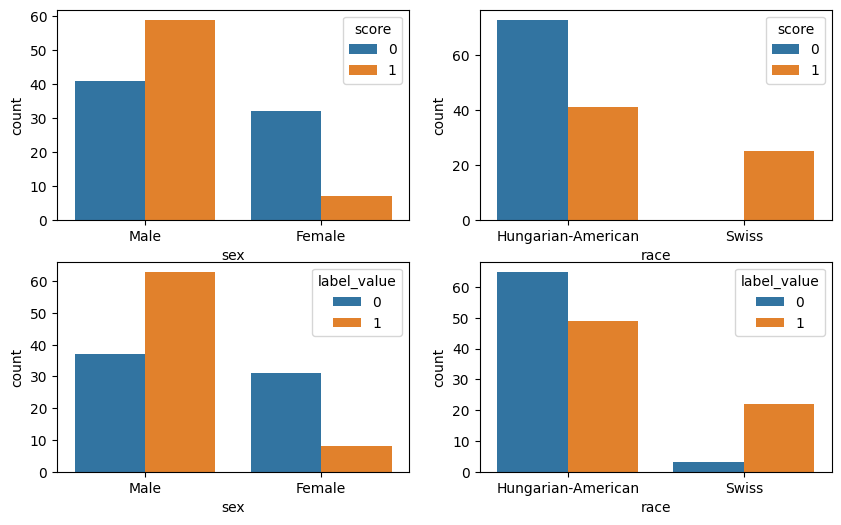

In [8]:
fig, ax = subplots(2, 2, figsize = (10, 6))

sns.countplot(x = "sex",  hue = "score", data = df_aeq, ax = ax[0][0]);
sns.countplot(x = "race", hue = "score", data = df_aeq, ax = ax[0][1]);

sns.countplot(x = "sex",  hue = "label_value", data = df_aeq, ax = ax[1][0]);
sns.countplot(x = "race", hue = "label_value", data = df_aeq, ax = ax[1][1]);

# 4. Visualize bias in the model ( Support Vector Classifier )

Based on the following slice of the crosstab dataframe, we can interpret 3 types of biases:

   * `Gender (Sex) bias`: The model performs significantly better on female individuals than on male individuals, as indicated by the higher TPR and precision values and lower FDR, FNR, and PPR values for females compared to males. This suggests that the model may have been trained on data that is biased towards female individuals, or that it may have learned gender stereotypes that are not reflective of the real-world data.
   
   
   * `Racial (Race) bias`: The model performs differently on individuals of different races, with Hungarian-Americans having higher TPR and TNR values than Swiss individuals, as well as lower FNR and higher PPR values. However, it is important to note that the data for Swiss individuals is incomplete, as indicated by the "NaN" values in some metrics. This suggests that the model may have been trained on data that is biased towards certain racial groups, or that it may have learned racial stereotypes that are not reflective of the real-world data.
   
   
   * `Class imbalance bias`: The prevalence of the target variable (i.e., the proportion of individuals with the outcome of interest) varies across different subgroups of the data. For example, the prevalence is higher for males than for females, and higher for Swiss individuals than for Hungarian-Americans. This can lead to biases in the model, as it may overemphasize or underemphasize certain subgroups of the data depending on the prevalence of the target variable.

In [9]:
# must discretize continuous attribute columns prior to passing the data to Group().get_crosstabs()
df_aeq, _ = preprocess_input_df(df_aeq)

g = Group()
xtab, _ = g.get_crosstabs(df_aeq)

In [10]:
absolute_metrics = g.list_absolute_metrics(xtab)

xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.88,1.00,0.03,0.00,0.00,0.12,0.97,1.00,0.11,0.18,0.21
1,sex,Male,0.76,0.70,0.37,0.19,0.30,0.24,0.63,0.81,0.89,0.59,0.63
2,race,Hungarian-American,0.67,0.88,0.22,0.20,0.12,0.33,0.78,0.80,0.62,0.36,0.43
3,race,Swiss,1.00,0.00,NaN,0.12,1.00,0.00,NaN,0.88,0.38,1.00,0.88


# 5. What levels of disparity exist between population groups?


The below dataframe shows the disparity in the model's performance across different subgroups, with the reference group being Male and Hungarian-American. Disparity refers to the extent to which the model's performance differs across subgroups, and can indicate the presence of bias or other issues in the model.

Looking at the data, we can see that there are disparities across different subgroups. For example, for the attribute `sex`, the model's performance for females is much lower than for males, as indicated by the low values for `ppr_disparity`, `pprev_disparity`, and `tpr_disparity`. This suggests that the model is not performing as well for female individuals as it is for males, and may be biased against this group.

Similarly, for the attribute `race`, we can see that the model's performance for Swiss individuals is significantly different from the reference group. The `pprev_disparity` value of 2.78 indicates that Swiss individuals are much more likely to be predicted as having heart disease by the model, compared to the reference group of Hungarian-American individuals. Additionally, the `tpr_disparity` value of 1.48 suggests that the model is more likely to correctly identify individuals from the Swiss group as having heart disease, but the `fpr_disparity` value of 8.125 indicates that the model is also more likely to incorrectly predict that individuals from this group have heart disease.

Overall, these disparities indicate that the model may have biases or other issues that need to be addressed in order to ensure that its outputs are accurate and fair across different subgroups.

In [11]:
b = Bias()

# automate base group selection based on dataset characterisitcs
# the reference group is Male and Hungarian-American and can be manually written
# but it is decided that Aequitas handles it.
majority_bdf = b.get_disparity_major_group(xtab, original_df = df_aeq)

majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

get_disparity_major_group()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,sex,Female,0.118644,0.304216,1.229167,0.000,0.085417,0.000,0.525,1.148438,1.423077,1.527644
1,sex,Male,1.000000,1.000000,1.000000,1.000,1.000000,1.000,1.000,1.000000,1.000000,1.000000
2,race,Hungarian-American,1.000000,1.000000,1.000000,1.000,1.000000,1.000,1.000,1.000000,1.000000,1.000000
3,race,Swiss,0.609756,2.780488,1.093333,0.615,NaN,8.125,0.000,1.484848,0.000000,NaN


# 6. How to assess the model fairness?

The dataframe below shows the model's performance on different parity-based fairness measures for two attributes, `race` and `sex`. For the `race` attribute, the model does not achieve `TNR parity`, but it achieves `Precision parity`. This means that the model is performing equally well for different races in terms of precision. The model also achieves `NPV parity` and `FOR parity`, which indicates equal performance in terms of negative predictive value and false omission rate. However, the model is not achieving any of the other parity-based fairness measures for this attribute.

For the `sex` attribute, the model achieves `TPR parity` and `Precision parity`, indicating that the model is performing equally well for males and females in terms of true positive rate and precision. However, the model is not achieving any of the other parity-based fairness measures for this attribute.

In summary, the model is not achieving all of the parity-based fairness measures for both the `race` and `sex` attributes, which suggests that there may be biases in the model that could lead to unfair outcomes for certain subgroups of individuals.

In [12]:
f = Fairness()
fdf = f.get_group_value_fairness(majority_bdf)

In [13]:
gaf = f.get_group_attribute_fairness(fdf)
gaf[['attribute_name'] + f.list_parities(fdf)]

,attribute_name,Supervised Fairness,FNR Parity,TNR Parity,TypeII Parity,Impact Parity,Unsupervised Fairness,Statistical Parity,TypeI Parity,FOR Parity,TPR Parity,Precision Parity,FPR Parity,FDR Parity,NPV Parity,Equalized Odds
0,race,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False
1,sex,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False


In [14]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}